<h2 align="center" style="color:blue">Feature Engineering</h2>

In [1]:
# Import necessary libraries
from imports import *

In [2]:
# Load cleaned dataset from processed folder
df = pd.read_parquet("../data/processed/processed.parquet")
print("Data loaded successfully:", df.shape)
df.head()

Data loaded successfully: (49908, 13)


,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [3]:
df.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

The `medical_history` column contains textual information about policyholders' pre-existing health conditions 
(e.g., *"Diabetes"*, *"High blood pressure"*, *"Heart disease"*, or combinations like *"Diabetes & Thyroid"*).  

Machine learning models cannot process text inputs directly, so this column is transformed into a **numeric health risk score**.  
The assumption is that a higher number or severity of diseases correlates with a higher premium.  

In [4]:
# Define risk scores for each medical condition
# Each disease is assigned a base risk score reflecting its relative severity:
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure": 6,
    "thyroid": 5,
    "no disease": 0,
    "none": 0
}

In [5]:
# Split combined conditions (e.g., "Diabetes & Heart disease") into separate columns
# convert all text to lowercase for consistency
df[['disease1', 'disease2']]= df['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())

df.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,None


In [6]:
# Replace missing entries with 'none' to handle single-condition or empty cases
df['disease1'].fillna('none', inplace=True)
df['disease2'].fillna('none', inplace=True)

# Initialize a new column for total risk score
df['total_risk_score'] = 0

# Add up risk scores from both disease columns
for disease in ['disease1', 'disease2']:
    df['total_risk_score'] += df[disease].map(risk_scores)

For individuals with multiple conditions (e.g., *"Diabetes & Heart disease"*), scores are **summed** to obtain a `total_risk_score`, 
which is then **normalized between 0 and 1** for use in the model.

In [7]:
# Normalize the total risk score between 0 and 1 for model compatibility
max_score = df['total_risk_score'].max()
min_score = df['total_risk_score'].min()

df['normalized_risk_score'] = (df['total_risk_score'] - min_score) / (max_score - min_score)

# Preview transformed features
df.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571


This derived feature (`normalized_risk_score`) quantifies the overall health risk associated with each policyholder.

### Ordinal Encoding for Ordered Categorical Variables

Some categorical features in the dataset have an inherent order or hierarchy — these are best handled using **label (ordinal) encoding** instead of one-hot encoding.  

In [8]:
# Inspect unique values in the insurance_plan column
df.insurance_plan.unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

1. **Insurance Plan**  
   - Plans follow a natural rank based on coverage level and premium value:  
     `Bronze < Silver < Gold`.  
   - These are encoded as `1`, `2`, and `3` respectively.

In [9]:
# Encode ordinal relationship: Bronze < Silver < Gold
df['insurance_plan'] = df['insurance_plan'].map({
    'Bronze': 1, 'Silver': 2, 'Gold': 3
})

# Verify encoded values
df.insurance_plan.unique()

array([1, 2, 3])

2. **Income Level**  
   - Income categories also follow an ascending order:  
     `<10L < 10L - 25L < 25L - 40L < >40L`.  
   - These are encoded as `1`, `2`, `3`, and `4`.

In [10]:
# Encode ascending income levels
df['income_level'] = df['income_level'].map({
    '<10L': 1, '10L - 25L': 2, '25L - 40L': 3,'> 40L': 4 
})

3. **BMI Category**  
   - BMI categories also follow an ascending order:  
     `Underweight < Normal < Overweight < Obesity`.  
   - These are encoded as `1`, `2`, `3`, and `4`.

In [11]:
# Inspect unique values in the bmi_category column
df['bmi_category'].unique()

array(['Normal', 'Obesity', 'Overweight', 'Underweight'], dtype=object)

In [12]:
# Encode ascending bmi categories
df['bmi_category'] = df['bmi_category'].map({
    'Underweight': 1, 'Normal': 2, 'Overweight': 3,'Obesity': 4 
})

In [13]:
# Preview the updated dataset
df.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,2,No Smoking,Salaried,1,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,4,Regular,Salaried,1,6,Diabetes,1,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,2,No Smoking,Self-Employed,2,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571


### One-Hot Encoding for Nominal Categorical Variables 

Nominal features have **no intrinsic order** between their categories, 
so they are encoded using **one-hot encoding**, where each category becomes a separate binary column (0 or 1).  

The following nominal variables are encoded:
- `gender`
- `region`
- `marital_status`
- `smoking_status`
- `employment_status`

In [14]:
# Define nominal categorical columns for one-hot encoding
nominal_cols = ['gender', 'region', 'marital_status', 'smoking_status', 'employment_status']

# Apply one-hot encoding using pandas get_dummies
# drop_first=True → drops one column per feature to avoid multicollinearity
# dtype=int → ensures the new columns are integer (0/1) instead of boolean
df3 = pd.get_dummies(df, columns=nominal_cols, drop_first=True, dtype=int)

To prevent multicollinearity, `drop_first=True` is used, which drops the first dummy column for each feature.  
This means that for binary variables like `marital_status`, only **one column** remains —  
`marital_status_Unmarried`, where:
- `1` = Unmarried  
- `0` = Married  

This keeps the encoding efficient while retaining all the necessary information.

In [15]:
df3.head(3)

,age,number_of_dependants,bmi_category,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,...,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,2,1,6,Diabetes,1,9053,diabetes,none,...,0.428571,1,1,0,0,1,0,0,1,0
1,29,2,4,1,6,Diabetes,1,16339,diabetes,none,...,0.428571,0,0,1,0,0,0,1,1,0
2,49,2,2,2,20,High blood pressure,2,18164,high blood pressure,none,...,0.428571,0,0,0,0,0,0,0,0,1


### Dropping Redundant or Intermediate Columns

After creating the `normalized_risk_score` feature from the `medical_history` column,  
the following columns have become redundant and are no longer needed for modeling:

- **`medical_history`** → Original text field (replaced by numeric risk score)  
- **`disease1`** → Temporary helper column used to split multi-condition entries  
- **`total_risk_score`** → Intermediate unscaled risk score (now represented by normalized version)

These columns are dropped to keep the dataset clean and prevent unnecessary variables 
from entering the model training phase.

In [16]:
# Drop redundant or intermediate columns after feature engineering
# - 'medical_history' (raw text column)
# - 'disease1' (temporary helper column)
# - 'disease2' (temporary helper column)
# - 'total_risk_score' (unscaled version of normalized score)
df4 = df3.drop(['medical_history', 'disease1', 'disease2','total_risk_score'], axis=1)

# Verify the resulting dataframe
df4.head(3)

,age,number_of_dependants,bmi_category,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,2,1,6,1,9053,0.428571,1,1,0,0,1,0,0,1,0
1,29,2,4,1,6,1,16339,0.428571,0,0,1,0,0,0,1,1,0
2,49,2,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,1


### Standardizing Column Names

To maintain consistency across all features and prevent case sensitivity issues during modeling or deployment, all column names are converted to lowercase.  

This ensures uniform naming conventions and cleaner downstream processing.

In [17]:
# Convert all column names to lowercase for consistency
df4.columns = df4.columns.str.lower()

# Verify the resulting dataframe
df4.head(3)

,age,number_of_dependants,bmi_category,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_male,region_northwest,region_southeast,region_southwest,marital_status_unmarried,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self-employed
0,26,0,2,1,6,1,9053,0.428571,1,1,0,0,1,0,0,1,0
1,29,2,4,1,6,1,16339,0.428571,0,0,1,0,0,0,1,1,0
2,49,2,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,1


### Feature Correlation Analysis

Before moving on to model training, it’s important to examine correlations between all numeric features.  
This helps to:
- Identify **strongly correlated predictors**, which may introduce multicollinearity (e.g., `income_level` and `income_lakhs`).  
- Understand which variables are most related to the **target variable** (`annual_premium_amount`).  
- Detect any redundant or highly dependent features that may be dropped or regularized later.

The heatmap below shows the pairwise Pearson correlation coefficients for all numerical features after feature engineering.  
Lighter colors indicate stronger positive correlations, while darker shades represent negative correlations.

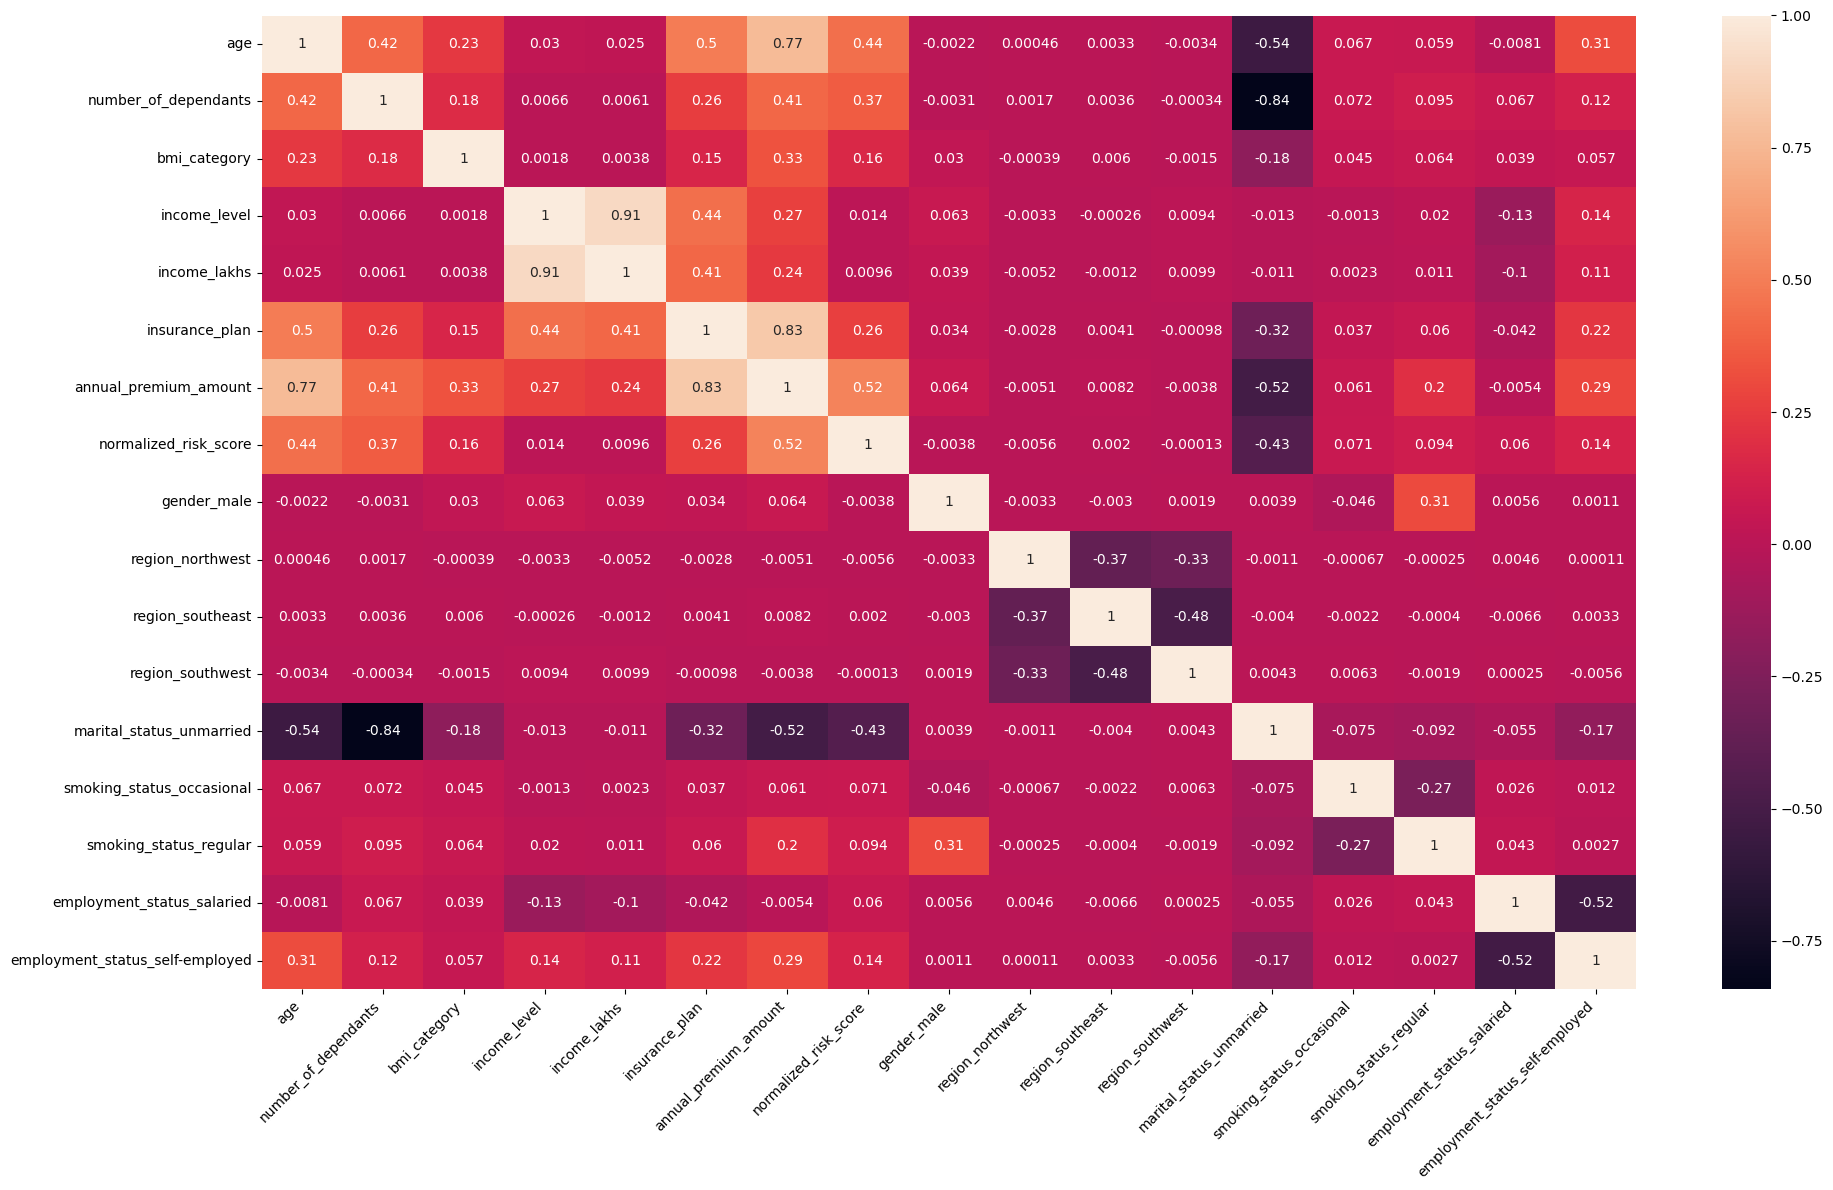

In [18]:
# Compute correlation matrix for all numerical features
cm = df4.corr()

# Set figure size for better readability
plt.figure(figsize=(20,12))

# Plot heatmap with correlation coefficients
sns.heatmap(cm, annot=True)

# Rotate axis labels for clarity
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust layout to prevent label overlap
plt.tight_layout()

# Save figure for documentation and reproducibility
plt.savefig("../outputs/figures/overall/fe_correlation_heatmap.png", dpi=300)

# Display the heatmap
plt.show()

### Observations
- `age`, `insurance_plan`, and `normalized_risk_score` show **moderate positive correlation** with `annual_premium_amount`, 
  indicating that older policyholders, higher-tier plans, and higher health risk tend to increase premium amounts.
- `income_level` and `income_lakhs` are **strongly correlated (≈ 0.9)**, meaning one may be redundant for modeling.
- `marital_status_unmarried` and `number_of_dependants` exhibit a strong **negative correlation**, which aligns logically 
  (unmarried individuals tend to have fewer dependents).

This correlation analysis will guide feature selection and regularization decisions in the model training phase.

In [19]:
df4.to_parquet("../data/processed/processedfe.parquet", index=False)
print("Processed data saved to ../data/processed/processedfe.parquet")

Processed data saved to ../data/processed/processedfe.parquet


In [20]:
df4.head(4)

,age,number_of_dependants,bmi_category,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_male,region_northwest,region_southeast,region_southwest,marital_status_unmarried,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self-employed
0,26,0,2,1,6,1,9053,0.428571,1,1,0,0,1,0,0,1,0
1,29,2,4,1,6,1,16339,0.428571,0,0,1,0,0,0,1,1,0
2,49,2,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,1
3,30,3,2,4,77,3,20303,0.000000,0,0,1,0,0,0,0,1,0


### Feature Scaling

Machine learning algorithms perform better when numeric features are on a comparable scale,  especially models that rely on distance or gradient-based optimization (e.g., Linear Regression, SVM, Neural Networks).  

Here, we:
1. Separate the dataset into:
   - **X** → feature variables (predictors)
   - **y** → target variable (`annual_premium_amount`)
2. Apply **Min–Max Scaling** to numeric columns so that all values are scaled between **0 and 1**.

This ensures that features like `income_lakhs` (which may have large values)  don’t dominate smaller-scaled variables like `age` or `number_of_dependants` during training.

In [21]:
# Separate features (X) and target variable (y)
X = df4.drop('annual_premium_amount', axis='columns')
y = df4['annual_premium_amount']

# Select columns to be scaled
cols_to_scale = ['age', 'number_of_dependants', 'bmi_category', 'income_level', 'income_lakhs', 'insurance_plan']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply scaling to the selected columns
# This transforms all selected features to a [0, 1] range
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])

# Display scaled feature values for verification
X.head(4)

,age,number_of_dependants,bmi_category,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_male,region_northwest,region_southeast,region_southwest,marital_status_unmarried,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self-employed
0,0.148148,0.0,0.333333,0.000000,0.050505,0.0,0.428571,1,1,0,0,1,0,0,1,0
1,0.203704,0.4,1.000000,0.000000,0.050505,0.0,0.428571,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.333333,0.333333,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,0.333333,1.000000,0.767677,1.0,0.000000,0,0,1,0,0,0,0,1,0


In [22]:
# Save the MinMaxScaler object for future use (inverse scaling & model deployment)
from joblib import dump

dump(scaler, "../outputs/models/minmax_scaler.pkl")  
print("Scaler saved successfully.")

Scaler saved successfully.


In [23]:
dump(cols_to_scale, "../outputs/models/cols_to_scale.pkl")

print("cols_to_scale saved successfully.")

cols_to_scale saved successfully.


### Verification of Scaling
All scaled features should now have a **minimum of 0** and a **maximum of 1**, confirming that Min–Max normalization was applied correctly.

In [24]:
X.describe()

,age,number_of_dependants,bmi_category,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_male,region_northwest,region_southeast,region_southwest,marital_status_unmarried,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self-employed
count,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.00000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000
mean,0.303733,0.343528,0.454096,0.365900,0.221110,0.397401,0.291831,0.549631,0.20093,0.350385,0.303038,0.513545,0.138274,0.313857,0.419412,0.272041
std,0.253363,0.298406,0.303328,0.349711,0.223946,0.392459,0.287420,0.497536,0.40070,0.477095,0.459576,0.499822,0.345191,0.464064,0.493468,0.445015
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.074074,0.000000,0.333333,0.000000,0.060606,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.240741,0.400000,0.333333,0.333333,0.161616,0.500000,0.357143,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.600000,0.666667,0.666667,0.303030,0.500000,0.428571,1.000000,0.00000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Multicollinearity Check using Variance Inflation Factor (VIF)

To ensure that features are not highly collinear, the **Variance Inflation Factor (VIF)** is calculated for each variable.  
VIF quantifies how much the variance of a regression coefficient is inflated due to multicollinearity.

In [25]:
# Function to calculate Variance Inflation Factor (VIF)
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [26]:
# Calculate VIF for all features
vif_before = calculate_vif(X)

# Display the initial VIF table
display(vif_before)

,Column,VIF
0,age,4.608490
1,number_of_dependants,4.670619
2,bmi_category,3.382992
3,income_level,12.447040
4,income_lakhs,11.183836
5,insurance_plan,3.583747
6,normalized_risk_score,2.693927
7,gender_male,2.413816
8,region_northwest,2.104991
9,region_southeast,2.926351


**Interpretation:**
- VIF ≈ 1 → No multicollinearity  
- 1 < VIF ≤ 5 → Moderate correlation (acceptable)  
- VIF > 10 → High multicollinearity (feature should be considered for removal)

Both `income_level` and `income_lakhs` showed high VIF values (>10), confirming redundancy observed in the correlation matrix.

In [27]:
# Recalculate VIF after removing the redundant feature
vif_after = calculate_vif(X.drop('income_level', axis='columns'))
display(vif_after)

,Column,VIF
0,age,4.586403
1,number_of_dependants,4.662060
2,bmi_category,3.382932
3,income_lakhs,2.478657
4,insurance_plan,3.445159
5,normalized_risk_score,2.693649
6,gender_male,2.402304
7,region_northwest,2.103118
8,region_southeast,2.923541
9,region_southwest,2.671405


Following best practice, `income_level` was dropped, and the VIFs were recalculated — all now below 5, indicating an acceptable feature set.

### Saving VIF Results

In [28]:
# Save VIF results to CSV files
vif_before.to_csv("../outputs/tables/overall/vif_before_reduction.csv", index=False)
vif_after.to_csv("../outputs/tables/overall/vif_after_reduction.csv", index=False)

Both the initial and revised VIF tables are saved under `outputs/tables/` for traceability.  
These files document the feature selection process and serve as a reference for model explainability.

In [29]:
# Based on results, remove 'income_level' (highly correlated with income_lakhs)
X_reduced = X.drop('income_level', axis='columns')
X_reduced.head()

,age,number_of_dependants,bmi_category,income_lakhs,insurance_plan,normalized_risk_score,gender_male,region_northwest,region_southeast,region_southwest,marital_status_unmarried,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self-employed
0,0.148148,0.0,0.333333,0.050505,0.0,0.428571,1,1,0,0,1,0,0,1,0
1,0.203704,0.4,1.000000,0.050505,0.0,0.428571,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.333333,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,0.333333,0.767677,1.0,0.000000,0,0,1,0,0,0,0,1,0
4,0.000000,0.0,0.666667,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,1


In [30]:
X_reduced.shape

(49908, 15)

In [31]:
y.shape

(49908,)

In [32]:
type(X_reduced)

pandas.core.frame.DataFrame

In [33]:
type(y)

pandas.core.series.Series

In [34]:
# Save final feature matrix (X_reduced) for model training
X_reduced.to_parquet("../data/processed/overall_final_features.parquet", index=False)

# Save target variable (y) as a Parquet file
# Converting to DataFrame only for saving; will load as Series in the next notebook
y.to_frame().to_parquet("../data/processed/overall_target_variable.parquet", index=False)

print("Saved X_reduced and y for model training.")

Saved X_reduced and y for model training.
